Install Desired packages first, lavis requires restarting session so better to restart first before proceeding.

In [1]:
!pip install chromadb
!pip install salesforce-lavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.4 MB/s eta 0:00:00


Imports

In [17]:
import warnings
warnings.filterwarnings('ignore')

import chromadb
import tarfile
import pickle
import pandas as pd
from tqdm import tqdm
from PIL import Image
from IPython.display import display, HTML
from base64 import b64encode
from google.colab import drive

import torch
from torch import cuda

Mount google drive to access datasets.

In [3]:
drive.mount('/gdrive', force_remount=True)
%ls /gdrive

project_dir="/gdrive/MyDrive/Interview Kickstart/MLSwitchup/Capstone/ShopTalk"
datasets_dir = project_dir + '/datasets'
embeddings_dir = datasets_dir + '/embeddings'
models_dir = project_dir + '/models'
assets_dir = project_dir + '/assets'

Mounted at /gdrive
MyDrive/  Othercomputers/


Read the EDA processed ABO listing dataset

In [4]:
abo_listing_df = pd.read_pickle(datasets_dir + '/abo-listings-final-draft.pkl')
abo_listing_df.head()

,brand,bullet_point,color,fabric_type,item_name,item_weight,model_name,product_type,style,main_image_id,other_image_id,country,marketplace,domain_name,material,item_keywords,pattern,model_year,product_description,finish_type
item_id,,,,,,,,,,,,,,,,,,,,
B0857LSVB7,Amazon Brand - Solimo,"[Snug fit for Samsung Galaxy J2 Ace, with perf...",Multicolor,NaN,Amazon Brand - Solimo Designer Lion UV Printed...,50,Samsung Galaxy J2 Ace,CELLULAR PHONE CASE,NaN,81-DuD5XzmL,"[61+woWTqkwL, 61SE4RTPjdL]",IN,Amazon,amazon.in,Silicon,"[Back Cover, Designer Case, Designer Lion Mobi...",NaN,NaN,NaN,NaN
B07C5FF8QS,AmazonBasics,"For best performance, follow the manufacturer'...",NaN,NaN,"AmazonBasics High Mileage Motor Oil, Synthetic...",NaN,NaN,AUTO OIL,High Mileage - Synthetic Blend,81YCp3dcurL,"[817GQ6xx-QL, 81Vr9poKgCL]",SG,Amazon,amazon.sg,NaN,"[oil, mobil 1, penzoil, castrol gtx, 5W-20, 5W...",10W-30,NaN,NaN,NaN
B07TG425LX,Amazon Brand - Solimo,[3D Printed Hard Back Case Mobile Cover for Hu...,Others,NaN,Amazon Brand - Solimo Designer Semi Circle Tex...,50,Huawei P9 lite,CELLULAR PHONE CASE,NaN,71ZoXfUr-sL,"[81IiaAkE6UL, 61Xce1Hq7DL, 61ATVyzpLKL, 61oI69...",IN,Amazon,amazon.in,NaN,"[mobile cover, back cover, mobile case, phone ...",NaN,NaN,NaN,NaN
B07LCHFZCW,Amazon Go,NaN,NaN,NaN,"Amazon Kitchen, Cajun Style Potato Salad, 7.2 oz",NaN,NaN,GROCERY,NaN,61bCuBtuZ4L,"[61njweKAz7L, 61UEtH+yC3L]",US,Amazon,amazon.com,NaN,NaN,NaN,NaN,NaN,NaN
B077W2YX72,Wickedly Prime,"[One 44-ounce plastic tub, Contains wheat, pea...",NaN,NaN,"Wickedly Prime Peanut Butter-Filled Pretzels, ...",2.8,NaN,GROCERY,NaN,71QbaO8qZIL,"[51M39MBAwDL, 71F6YzH37XL, 71d7-4rSVlL, 61ucPj...",US,AmazonGo,amazon.com/go,NaN,"[pretzels, peanut butter, peanut butter pretze...",NaN,NaN,NaN,NaN


Prepare image dataset

In [5]:
!wget -nc https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar

tar = tarfile.open("abo-images-small.tar")
tar.extractall()
tar.close()

!gunzip -f 'images/metadata/images.csv.gz'

images_df = pd.read_csv('images/metadata/images.csv').set_index('image_id')
images_df.head()

--2025-01-03 08:19:14--  https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar
Resolving amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)... 52.217.95.185, 52.217.116.105, 16.182.102.153, ...
Connecting to amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)|52.217.95.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3253381120 (3.0G) [application/x-tar]
Saving to: ‘abo-images-small.tar’

abo-images-small.ta 100%[===================>]   3.03G  23.6MB/s    in 2m 31s  

2025-01-03 08:21:46 (20.5 MB/s) - ‘abo-images-small.tar’ saved [3253381120/3253381120]



,height,width,path
image_id,,,
010-mllS7JL,106,106,14/14fe8812.jpg
01dkn0Gyx0L,122,122,da/daab0cad.jpg
01sUPg0387L,111,111,d2/d2daaae9.jpg
1168jc-5r1L,186,186,3a/3a4e88e6.jpg
11RUV5Fs65L,30,500,d9/d91ab9cf.jpg


Helper function to correctly formulate html tags for images from image id. Adapted from source: https://stackoverflow.com/questions/49478791/how-can-i-open-images-in-a-google-colaboratory-notebook-cell-from-uploaded-png-f


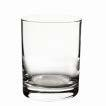

In [6]:
def get_image_html(image_id, width=None, height=None):
    mime_type = None
    path_to_image = 'images/small/' + images_df.loc[image_id, 'path']
    path_to_image = path_to_image.lower()

    # More MIME types:
    # https://developer.mozilla.org/en-US/docs/Web/HTTP/Basics_of_HTTP/MIME_types
    if path_to_image.endswith('.jpg') or path_to_image.endswith('.jpeg'):
        mime_type = 'image/jpeg'
    elif path_to_image.endswith('.png'):
        mime_type = 'image/png'
    elif path_to_image.endswith('.gif'):
        mime_type = 'image/gif'
    else:
        raise ValueError('Unknown extension: %s' % (path_to_image))

    img = open(path_to_image, 'rb').read()
    data_url = 'data:image/jpeg;base64,' + b64encode(img).decode()

    width_str = "width='%d'" % (width) if width is not None else ''
    height_str = "height='%d'" % (width) if height is not None else ''

    return "<img src='%s' %s%s>" % (data_url, width_str, height_str)

display(HTML(get_image_html('010-mllS7JL')))

Helper Method to display a product listing

Column,Value
brand,Amazon Brand - Solimo
bullet_point,"Snug fit for Vivo V9, with perfect cut-outs for volume buttons, audio and charging portsCompatible with Vivo V9Easy to put & take off with perfect cutouts for volume buttons, audio & charging ports.Stylish design and appearance, express your unique personality.Extreme precision design allows easy access to all buttons and ports while featuring raised bezel to life screen and camera off flat surface."
color,Multicolor
fabric_type,nan
item_name,Amazon Brand - Solimo Designer Lake View UV Printed Soft Back Case Mobile Cover for Vivo V9
item_weight,50
model_name,Vivo V9
product_type,CELLULAR PHONE CASE
style,nan
main_image_id,

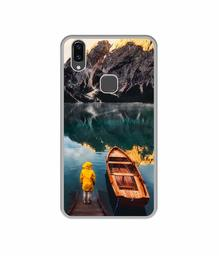
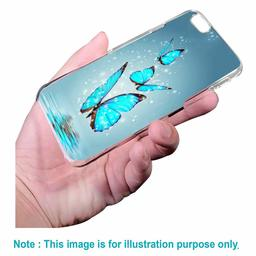
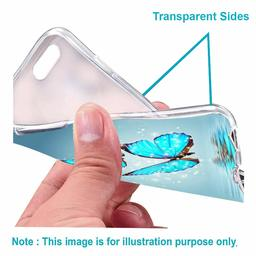

In [7]:
def display_product(item_id):
  html_string = "<table border='1'>"
  html_string += "<tr><th>Column</th><th>Value</th></tr>"

  row = abo_listing_df.loc[item_id]
  for col_name, value in row.items():
    if col_name == 'main_image_id':
      value = get_image_html(value)
    elif col_name == 'other_image_id':
      value = "".join(get_image_html(image_id) for image_id in value)
    elif isinstance(value, list):
      list_html = "<ul>" + "".join(f"<li>{item}</li>" for item in value) + "</ul>"
      value = list_html
    html_string += f"<tr><td>{col_name}</td><td>{value}</td></tr>"

  html_string += "</table>"
  display(HTML(html_string))

random_row_key = abo_listing_df.sample(n=1).index[0]
display_product(random_row_key)

Load precreated embeddings from pickle file.

In [9]:
embeddings_abo_df = pd.read_pickle(embeddings_dir + '/old/embeddings_abo.pkl')
embeddings_abo_df.head()

,image_id,item_id,embedding
0,81-DuD5XzmL,B0857LSVB7,"[-0.52192634, -0.46416232, 0.005269423, -0.792..."
1,61+woWTqkwL,B0857LSVB7,"[-0.18547179, -0.6788964, 0.10444248, -0.36741..."
2,61SE4RTPjdL,B0857LSVB7,"[-0.009377651, -0.60804415, 0.0016542991, -0.3..."
3,81YCp3dcurL,B07C5FF8QS,"[0.80878174, -0.4682043, 1.0941213, -0.8250118..."
4,817GQ6xx-QL,B07C5FF8QS,"[1.0564034, -0.16991387, 0.9090485, -0.3455055..."


ABO dataset is very imbalanced for different product types, examine counts per product type below.

In [10]:
embeddings_abo_df['product_type'] = embeddings_abo_df['item_id'].apply(lambda x: abo_listing_df.loc[x, 'product_type'])
embeddings_abo_df['product_type'].value_counts()

,count
product_type,
CELLULAR PHONE CASE,280832
SHOES,53651
GROCERY,29867
HOME,10933
CHAIR,9200
...,...
STROLLER,1
ELECTRONIC SWITCH,1
FASHION OTHER,1


As we see above, number of samples in each product type varies alot. Also to process all items in this notebook consumes memory and CPU resources, which are not suitable to run in colab environment, we need to downsample input. Below function does samples items to have no more than 100 items per product category and keep atleast 5 (or all if < 5) samples for each category. For product count in between, we take 50% samples.

In [11]:
sample_fraction = 0.5  # % of Samples from each category

def dynamic_sample(group):
  sample_size = len(group) if len(group) <= 5 else int(len(group) * sample_fraction)
  sample_size = min(sample_size, 100)
  return group.sample(sample_size)

embeddings_abo_df = embeddings_abo_df.groupby('product_type', group_keys=False).apply(dynamic_sample)
embeddings_abo_df['product_type'].value_counts()

,count
product_type,
AUTO ACCESSORY,100
WRITING INSTRUMENT,100
ACCESSORY,100
ACCESSORY OR PART OR SUPPLY,100
AREA DEODORIZER,100
...,...
NECKTIE,1
TABLETOP GAME,1
CAMCORDER,1


Create a persistent chromadb client to store embeddings.

In [12]:
chroma_client = chromadb.PersistentClient(datasets_dir + "/abolisting.db")
chroma_client.delete_collection(name="abolistings")
collection = chroma_client.get_or_create_collection(name="abolistings")

Load embeddings to chromadb collection in batches of 1000.

In [13]:
batchsize = 1000
for i in tqdm(range(0, len(embeddings_abo_df), batchsize)):
  i_end = min(i+batchsize, len(embeddings_abo_df))
  batch = embeddings_abo_df.iloc[i:i_end]
  batch['image_id'] = batch['image_id'].fillna('')
  collection.add(
      embeddings=batch['embedding'].tolist(),
      ids=(batch['item_id'] + "#" + batch['image_id']).tolist())

100%|██████████| 24/24 [00:51<00:00,  2.16s/it]


Check count of embeddings loaded to the collection.

In [14]:
collection.count()

23170

Query the collection for very first embedding to verify if it retuns the same embeddings that we just loaded i.e. identity test.

In [15]:
results = collection.query(
    query_embeddings=[embeddings_abo_df.iloc[0]["embedding"]],
    n_results=5
)

print(embeddings_abo_df.iloc[0])
print(results)

image_id                                              81iMwJivqjL
item_id                                                B07ZXQ21V9
embedding       [-0.023193078, 0.20117564, -0.41889971, -0.503...
product_type                                            ACCESSORY
Name: 510105, dtype: object
{'ids': [['B07ZXQ21V9#81iMwJivqjL', 'B07ZXQ6HMR#71ucXDiRjEL', 'B07WNQJVBW#81p7bCwfSEL', 'B07574KZYH#915EzUwtnlL', 'B07WR33WVF#81qa-sNGlKL']], 'embeddings': None, 'documents': [[None, None, None, None, None]], 'uris': None, 'data': None, 'metadatas': [[None, None, None, None, None]], 'distances': [[0.0, 81.31641387939453, 94.32535552978516, 95.45459747314453, 98.99478149414062]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.documents: 'documents'>, <IncludeEnum.metadatas: 'metadatas'>]}


load serialized visual and text processor functions to prepare input images and text in format that BLIP2 model likes.

In [18]:
with open(assets_dir + "/blip-2-processors.pkl", 'rb') as f:
  vis_processor, text_processor = pickle.load(f)

Now load fine tuned BLIP2 model.

In [32]:
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

abo_finetuned_model = models_dir + "/blip-2-abo-trained-2epochs.pt"

model = torch.load(abo_finetuned_model, map_location=device)
model = model.float()
model = model.to(device)
model.eval()

Blip2Qformer(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-38): 39 x Block(
        (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1408, out_features=4224, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1408, out_features=1408, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1408, out_features=6144, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )


Let's try querying model with multimodal image and text based search with following 'sofa' image taken from abo dataset only.

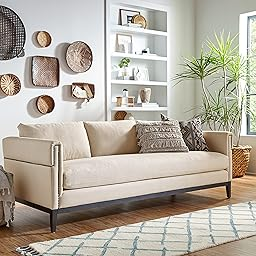

In [33]:
image = Image.open(datasets_dir + '/sofa.jpg')
display(image)

Preprare processed inputs and generate multmodal embeddings.

In [34]:
image = vis_processor(image).unsqueeze(0).to(device)
text = text_processor("Find similar sofa")

inputs = {"image": image, "text_input": text}

# find features of image and text target
multimodal_emb = model.extract_features(inputs).multimodal_embeds[0,0,:] # size (768)
print(multimodal_emb)

tensor([ 2.9439e-01,  1.4800e-01, -6.7374e-02,  1.8612e-01,  2.7427e-01,
         3.2090e-01, -6.3932e-02,  2.0459e-01,  1.4988e-01, -2.6333e-01,
        -4.8084e-01,  8.8927e-02,  2.6937e-01,  5.6051e-01,  1.1456e-01,
         2.6842e-01, -1.7918e-01, -2.5448e-01,  7.0350e-03, -1.7366e-01,
         4.4620e-01, -9.3783e-02, -4.2216e-01,  1.8814e-01,  3.7294e-01,
        -4.9688e-02,  4.9502e-01, -2.4155e-01,  1.6818e-01,  1.0511e-01,
         2.5919e-01,  2.7664e-01,  3.1012e-01,  1.6844e-01, -3.7405e-02,
        -2.5636e-01, -5.2580e-01,  6.7679e-01, -5.4962e-02, -3.8515e-01,
        -2.8209e-01, -2.9550e-01,  5.8163e-01,  5.4113e-01,  3.5072e-01,
        -2.9499e-01, -1.1197e+00,  2.7281e-01, -4.1490e-02,  1.9339e-01,
         2.3313e-01,  3.7062e-01,  3.3800e-01,  2.1531e-01, -2.4309e-01,
         2.8459e-01, -3.5227e-01,  3.1074e-01,  8.2036e-02,  3.3421e-01,
         1.8270e-01,  2.0931e-01,  3.7315e-02, -3.5617e-02,  1.7922e-02,
         3.4692e-01, -2.7073e-02, -2.7693e-01,  3.7

Now query chromadab collection with multimodal embeddings genrated above.

In [35]:
results = collection.query(
    query_embeddings=[multimodal_emb.tolist()],
    n_results=5
)

print(results)

{'ids': [['B07KXZ22GQ#A1pr0iYk-bL', 'B07J2JGXD7#A1tLfxXOzeL', 'B07F2X8FFL#71TZVYV-KxL', 'B07BWJCVL6#91TyHNHrf-L', 'B0723H97GH#A151jLxJubL']], 'embeddings': None, 'documents': [[None, None, None, None, None]], 'uris': None, 'data': None, 'metadatas': [[None, None, None, None, None]], 'distances': [[24.285343170166016, 33.98270797729492, 38.7011604309082, 40.51344680786133, 43.18717956542969]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.documents: 'documents'>, <IncludeEnum.metadatas: 'metadatas'>]}


Now display top 5 matches returned from Chromadb in HTML table format. As you can see, results are bunch of sofa similar to the input image.

Column,Value
brand,Stone & Beam
bullet_point,nan
color,nan
fabric_type,nan
item_name,Stone & Beam Westcott Modern Westcott Sofa Fabric
item_weight,nan
model_name,nan
product_type,SOFA
style,nan
main_image_id,

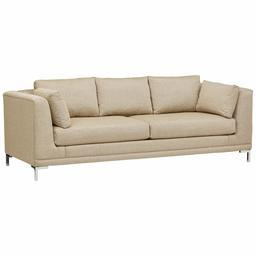
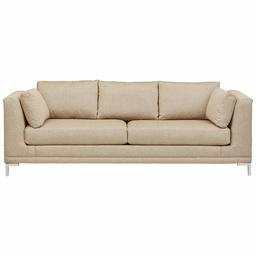
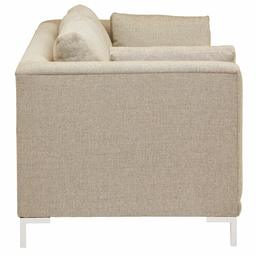
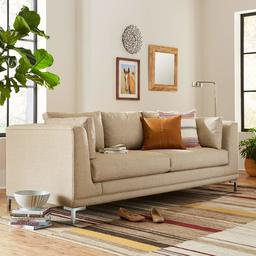
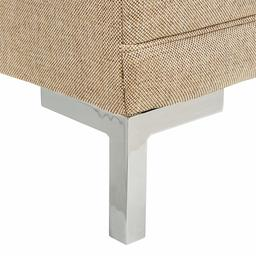
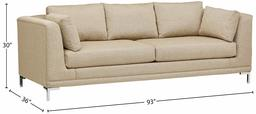
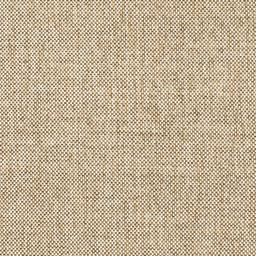
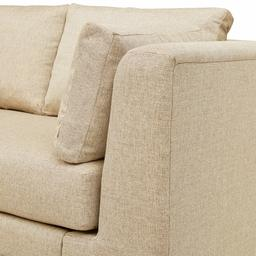
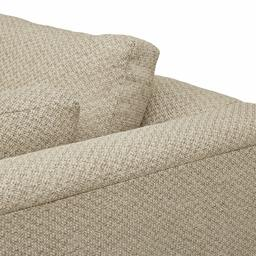
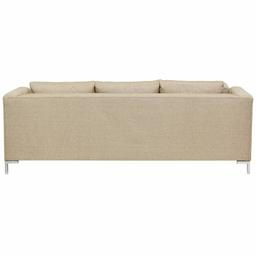

Column,Value
brand,Rivet
bullet_point,"Upgrade your living room style with this striking contemporary sofa. The stitching all along the edges shows off this sofa’s construction quality, and the slim armrests and silver metal legs complete its sleek look.Overall: 81""W x 34""D x 31""H; Seat Height: 17.71""H; Seat Depth: 21.65""D; Seat Back Height: 31""H; Arm Height: 23.22:H; Leg Height: 5.91""HSolid-wood frame with silver metal legsSlim arm with loose back cushionSimple assembly in less than 15 minutesFree returns for 30 days. 1-year warranty."
color,Navy
fabric_type,Fabric Metal
item_name,"Amazon Brand – Rivet Abel Modern Contemporary Sofa, 81""W, Navy"
item_weight,69
model_name,nan
product_type,SOFA
style,Transitional
main_image_id,

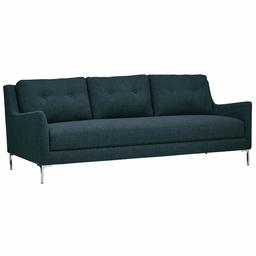
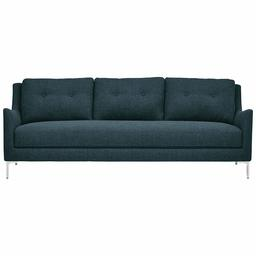
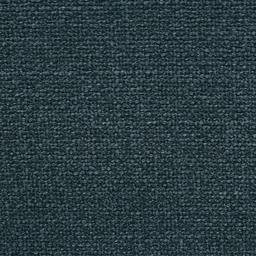
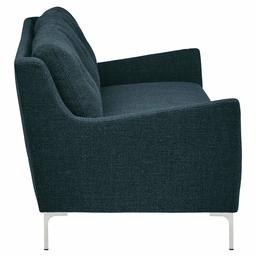
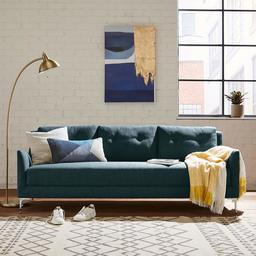
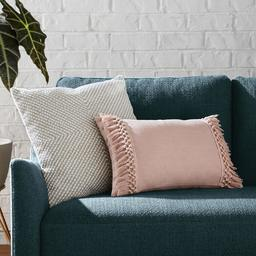
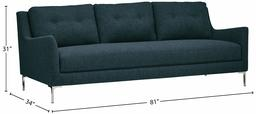

Column,Value
brand,Ravenna Home
bullet_point,nan
color,nan
fabric_type,nan
item_name,Amazon Brand – Ravenna Home Amanda Collection
item_weight,nan
model_name,nan
product_type,SOFA
style,nan
main_image_id,

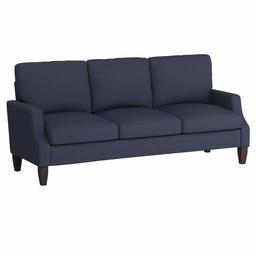
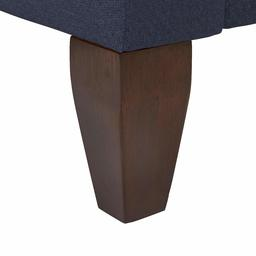
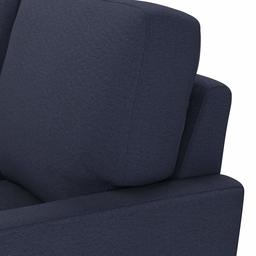
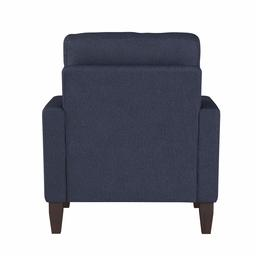
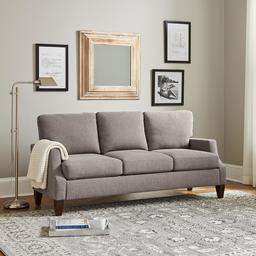
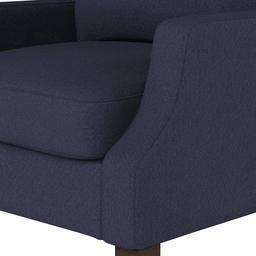
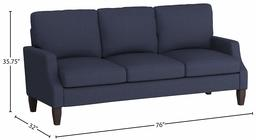
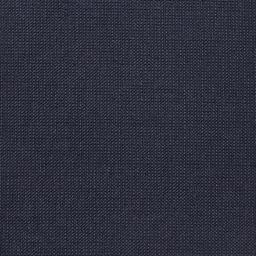
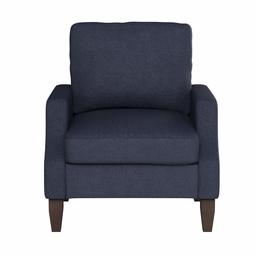
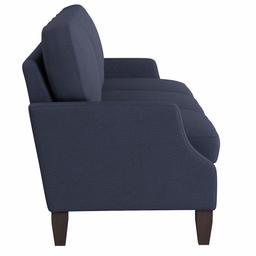
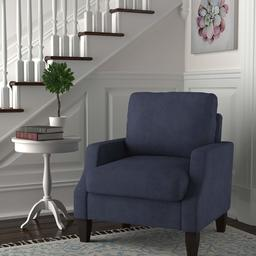

Column,Value
brand,Stone & Beam
bullet_point,"Complete your living space with this stylish sectional. With its stone-colored upholstery, this sectional is an ideal accent for transitional-style home decor. The solid-wood frame is stable, and reversible cushions enhance durability and extend this sectional’s life.Overall: 134""W x 96""D x 33""H; seat height: 21""H; seat depth: 25""D; seat back height: 28""H; arm height: 28""H; leg height: 4.25""H; chaise depth: 23""D; chaise width: 40""WSturdy wood frame with stain-resistant fabricTransitional style blends well with a variety of home-decor themes.Back and seat cushions are reversible so you can choose the configuration that's right for you.Assemble in 15 minutes or lessFree returns for 30 days. 3-year warranty.This item is made to order just for you."
color,Stone
fabric_type,Benavento Stone
item_name,"Amazon Brand – Stone & Beam Andover Slipcover Right-Facing U-Shaped Sectional, 134""W, Stone Fabric"
item_weight,173
model_name,nan
product_type,HOME FURNITURE AND DECOR
style,nan
main_image_id,

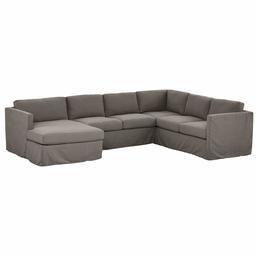
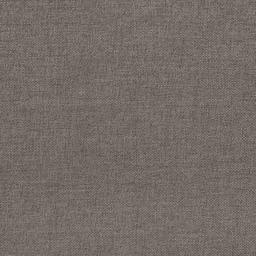
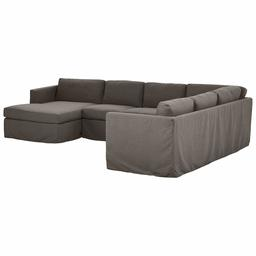
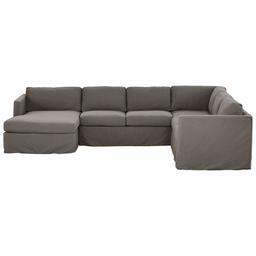
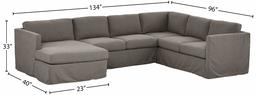
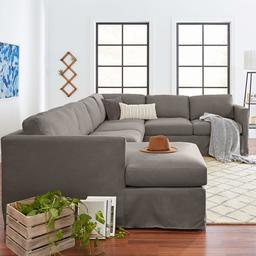

Column,Value
brand,Rivet
bullet_point,"Sturdy hardwood frame and solid beech wood legsMid-century modernRemovable cushions for easy cleaningSimple assembly; just attach legsFree returns for 30 days. 1-year warranty.Impress your friends with this mid-century modern style. The blocky silhouette of this chair, softened by hand tufting on the back pillow, will look sharp in your living room or anywhere else a fashionable chair is needed.33.8""D x 32.7”W x 35.4""H"
color,Dark Grey
fabric_type,nan
item_name,"Amazon Brand – Rivet Cove Modern Tufted Accent Chair with Tapered Legs, Mid-Century, 32.7""W, Dark Grey"
item_weight,51.9
model_name,nan
product_type,CHAIR
style,Mid-Century modern
main_image_id,

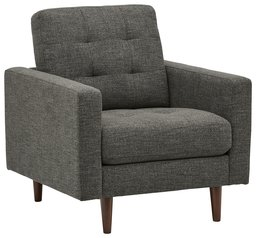
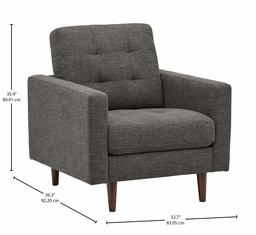
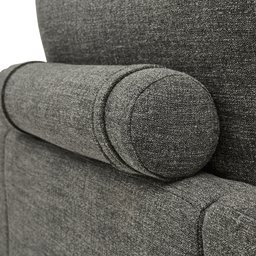
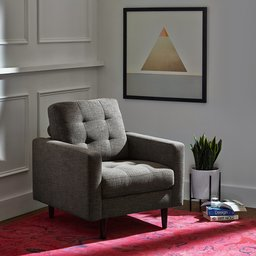
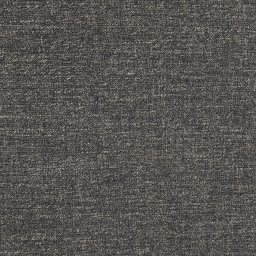

In [36]:
for id in results['ids'][0]:
  item_id, image_id = id.split('#')
  display_product(item_id)